In [1]:
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import csv
import pandas as pd
import seaborn as sns
import os

# Testing the new passive phase extraction algorithm

In [2]:
with open('data_path.txt', 'r') as f:
    data_path = os.path.join(f.readline(), 'virtual_stick')

In [3]:
def extract_passive_phases(v):
    is_previous_v_zero = False
    starting_points = []
    action_points = []
    for i in np.arange(0,len(v)):
        if v[i]==0:
            if not is_previous_v_zero:
                is_previous_v_zero = True
                starting_points += [i]
            elif (i==len(v)-1):
                action_points += [i]            
        elif (is_previous_v_zero):
            action_points += [i]
            is_previous_v_zero = False
    
    return starting_points, action_points

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


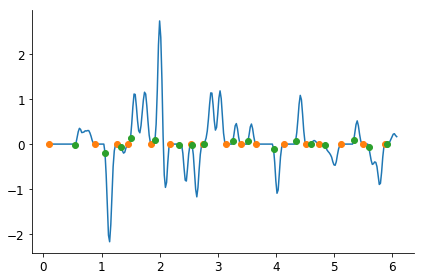

In [4]:
subjects = np.arange(1, 11)
file_path = os.path.join(data_path, 'fast', '%i.csv')

df_list = []
# for subject in subjects:
subject = 9
data = pd.read_csv(file_path % (subject),index_col=None, header=0, delimiter=',', names=['t','theta', 'dottheta', 'x', 'v'])
data.theta -= np.pi/2
data.v *= -1
data.t /= 1000000

data = data.iloc[0:300]
v = data.v
t = data.t
theta = data.theta

starting_points, action_points = extract_passive_phases(v)

plt.plot(t, v)
plt.plot(t[starting_points], v[starting_points], ls='', marker='o')
plt.plot(t[action_points], v[action_points], ls='', marker='o')

# Export passive phases data

In [5]:
subjects = np.arange(1, 11)
file_path=os.path.join(data_path, 'fast', '%i.csv')

dfs = []

for subject in subjects:
    data = pd.read_csv(file_path % (subject),index_col=None, header=0, delimiter=',', 
                       names=['t','theta', 'dottheta', 'x', 'v'])
    data['theta'] -= np.pi/2
    data['v'] *= -1
    data['t'] /= 1000000
    
    starting_points, action_points = extract_passive_phases(data['v'])
    
    sp = data.iloc[starting_points].theta.to_frame().reset_index(drop=True)
    ap = data.iloc[action_points].theta.to_frame().reset_index(drop=True)
    t_sp = data.iloc[starting_points].t.to_frame().reset_index(drop=True)
    t_ap = data.iloc[action_points].t.to_frame().reset_index(drop=True)
    df = pd.concat([sp, ap, t_sp, t_ap], axis=1, ignore_index=True)
    df.columns = ['sp', 'ap', 't_sp', 't_ap']
    df['subject'] = subject
    df['subject_scale'] = np.std(data['theta'])

    dfs.append(df)
    
passive_phases = pd.concat(dfs)

# We discard the records where action point is smaller than the starting point
# Such records are the result of concatenating multiple trials
passive_phases = passive_phases[abs(passive_phases['ap'])>abs(passive_phases['sp'])]

# Then, we switch to absolute values of start/action points, as these are apparently symmetric
passive_phases = abs(passive_phases)

# We also calculate the differences between action and starting point in terms of angle and time
passive_phases['delta_theta'] = passive_phases['ap'] - passive_phases['sp']
passive_phases['delta_t'] = passive_phases['t_ap'] - passive_phases['t_sp']

passive_phases['sp_scaled'] = passive_phases['sp']/passive_phases['subject_scale']
passive_phases['ap_scaled'] = passive_phases['ap']/passive_phases['subject_scale']    

passive_phases['sp_decile'] =pd.qcut(passive_phases['sp'], 10, labels=np.arange(1,11))
# passive_phases['sp_scaled_decile'] =pd.qcut(passive_phases['sp_scaled'], 10, labels=np.arange(1,11))

passive_phases.to_csv(os.path.join(data_path, 'passive_phases.csv'), float_format='%.5f', index=False)

In [6]:
passive_phases = pd.read_csv('passive_phases.csv', index_col=None)

def plot_pdf(data, var, ax=None, ls='-'):
    subjects = np.arange(1, 11)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    for subject in subjects:
        x = data.loc[data.subject==subject, var]
        hist, bins = np.histogram(x, bins=20, normed=True)
        hist[hist==0] = np.nan
        ax.plot((bins[1:] + bins[:-1])/2, hist, label=subject, ls=ls, alpha=0.8)

    ax.set_ylabel('pdf')
    ax.set_yscale('log')
    ax.set_ylim((0.005, 25))

    return ax

# Starting and action point distributions

First, let's look at the raw distributions of the starting and action points

(0, 1.5)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


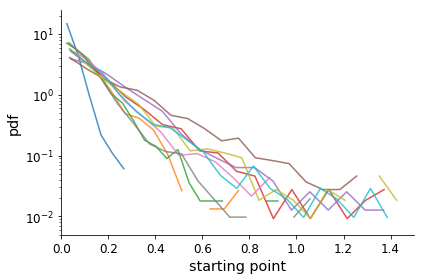

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


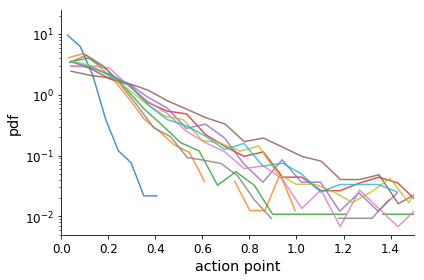

In [7]:
ax = plot_pdf(passive_phases, 'sp')
ax.set_xlabel('starting point')
ax.set_xlim((0, 1.5))

ax = plot_pdf(passive_phases, 'ap')
ax.set_xlabel('action point')
ax.set_xlim((0, 1.5))

And on the same plot (for clarity, only first five subjects are plotted). Solid lines are action points, dashed lines are starting points

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:842: RuntimeWarning: invalid value encountered in true_divide
  return n/(n*db).sum(), bin_edges


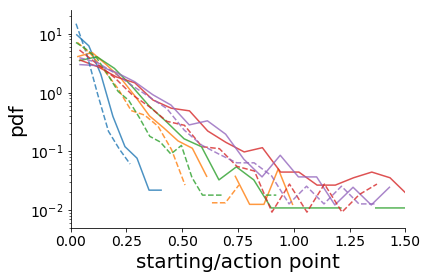

In [214]:
ax = plot_pdf(passive_phases[passive_phases.subject<6], 'ap')
ax.set_xlabel('starting/action point')

ax.set_xlim((0, 1.5))

ax = plot_pdf(passive_phases[passive_phases.subject<6], 'sp', ls='--', ax=ax)

And now, rescaled accounting for subject's stick oscillations amplitude

(0.001, 2)

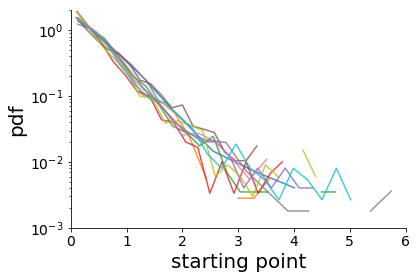

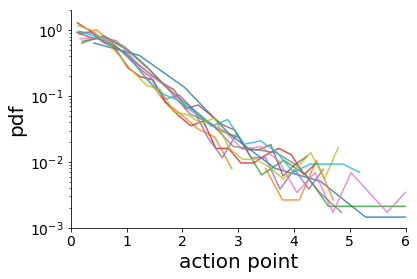

In [215]:
ax = plot_pdf(passive_phases, 'sp_scaled')
ax.set_xlabel('starting point')
ax.set_xlim((0, 6))
ax.set_ylim((0.001, 2))

ax = plot_pdf(passive_phases, 'ap_scaled')
ax.set_xlabel('action point')
ax.set_xlim((0, 6))
ax.set_ylim((0.001, 2))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:842: RuntimeWarning: invalid value encountered in true_divide
  return n/(n*db).sum(), bin_edges


(0.001, 2)

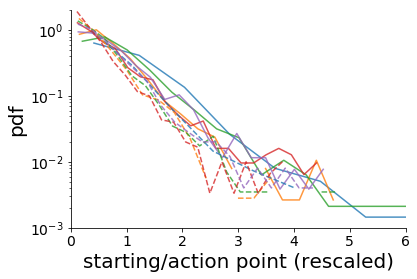

In [216]:
ax = plot_pdf(passive_phases[passive_phases.subject<6], 'ap_scaled')
ax = plot_pdf(passive_phases[passive_phases.subject<6], 'sp_scaled', ls='--', ax=ax)
ax.set_xlabel('starting/action point (rescaled)')
ax.set_xlim((0, 6))
ax.set_ylim((0.001, 2))

Overall, the difference between starting and action point distributions is noticeable, but not huge

(0, 7)

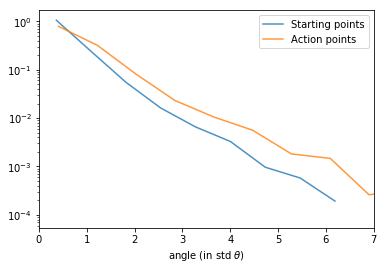

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
        
hist, bins = np.histogram(passive_phases.sp_scaled, bins=20, normed=True)
hist[hist==0] = np.nan
ax.plot((bins[1:] + bins[:-1])/2, hist, alpha=0.8, label='Starting points')

hist, bins = np.histogram(passive_phases.ap_scaled, bins=20, normed=True)
hist[hist==0] = np.nan
ax.plot((bins[1:] + bins[:-1])/2, hist, alpha=0.8, label='Action points')

ax.legend()

ax.set_yscale('log')

ax.set_xlabel(r'angle (in std $\theta$)')

ax.set_xlim((0, 7))

# Difference between action and starting point

Let's denote the difference between an action point and the preceding starting point as $\Delta \theta$. 

Its distribution also seems exponential in all subjects but one

(0.005, 25)

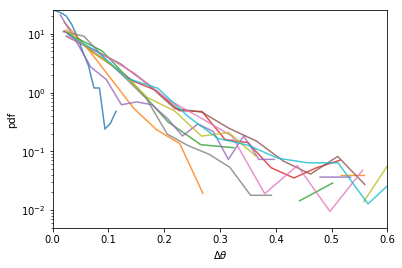

In [7]:
ax = plot_pdf(passive_phases, 'delta_theta')
ax.set_xlabel(r'$\Delta \theta$')
ax.set_xlim((0, 0.6))
ax.set_ylim((0.005, 25))

# Passive phase duration

Let's also take a look at how the passive phase duration (inter-adjustment interval) is distributed overall

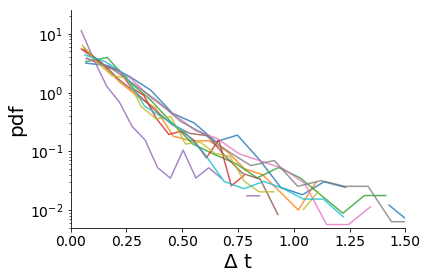

In [217]:
ax = plot_pdf(passive_phases, 'delta_t')
ax.set_xlabel('$\Delta$ t')
ax.set_ylabel('pdf')

ax.set_yscale('log')
ax.set_xlim((0, 1.5))
ax.set_ylim((0.005, 25));

# Bivariate distributions

Obviously, the action point can only be larger than the preceding starting point. It makes sense to look at the joint plot of two, just in case

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


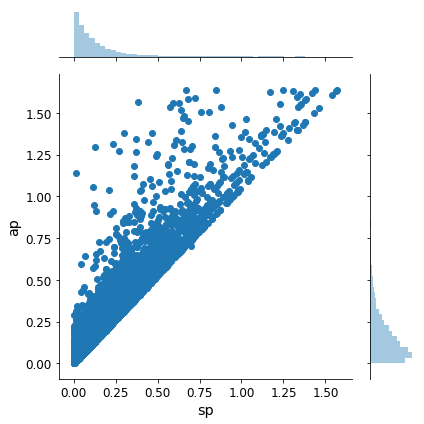

In [8]:
sns.jointplot(data=passive_phases, x='sp', y='ap')

It then turns out that the larger the starting point, the larger $\Delta \theta$

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


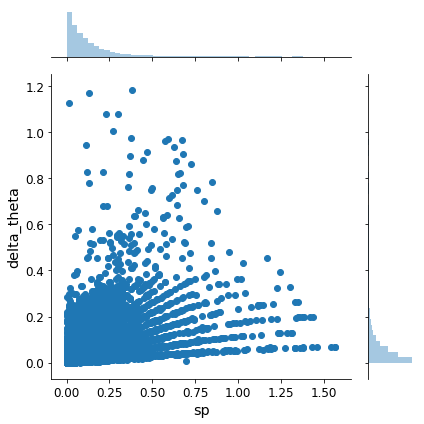

In [9]:
sns.jointplot(data=passive_phases, x='sp', y='delta_theta')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


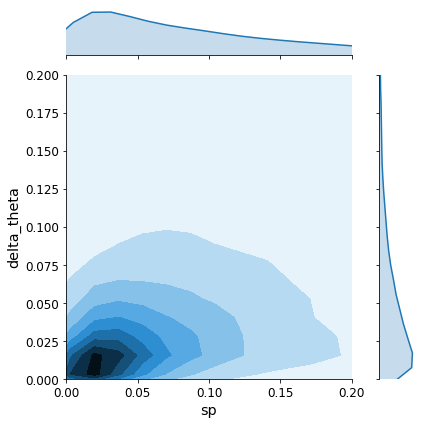

In [10]:
sns.jointplot(data=passive_phases, x='sp', y='delta_theta', kind='kde', xlim=(0, 0.2), ylim=(0, 0.2))

This isn't intuitive: I'd expect that for greater starting deviation, we'd react sooner and thus at smaller $\Delta \theta$. However, this can be caused by exponentially increasing $\theta$. Indeed, passive phase duration (inter-adjustment interval) decreases with starting point

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


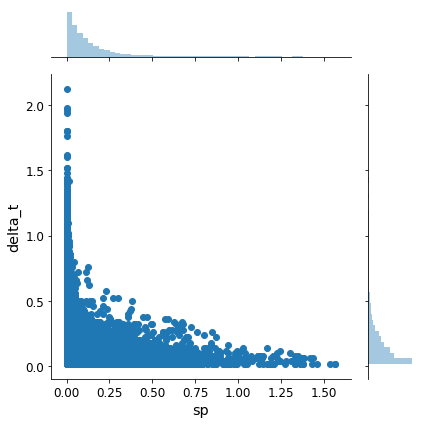

In [11]:
sns.jointplot(data=passive_phases, x='sp', y='delta_t')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


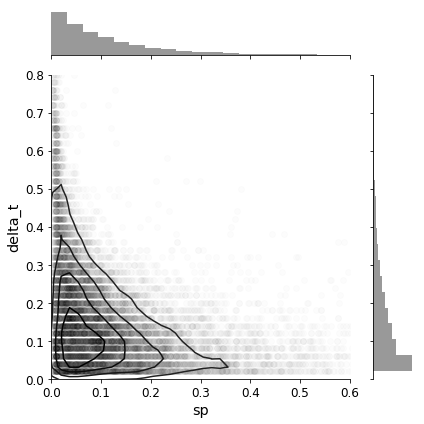

In [12]:
(sns.jointplot(data=passive_phases, x='sp', y='delta_t', alpha=0.01, xlim=(0, 0.6), ylim=(0, 0.8), color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

# Discretizing starting point?

The problem is that contrasting a model to experimental data is tricky for bivariate distributions... How about we discretize the values of the variable we'd like to control for (in this case, starting point)? We can do it in two ways: bins of fixed width, or bins of fixed size (e.g., deciles). I'd suggest using fixed-size bins, as we can more reliably compare different bins, because they'll have exactly the same number of data points

Now we can clearly compare how average action point changes with starting point between the model and the data

C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


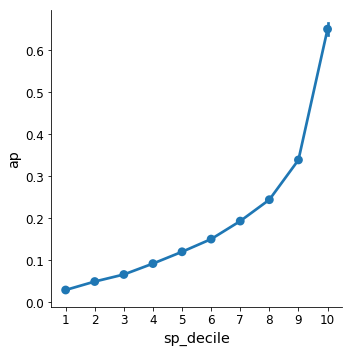

In [14]:
sns.factorplot(data=passive_phases, x='sp_decile', y='ap', kind='point')

Similarly, $\Delta \theta = \text{action point - starting point}$ increases with starting point

C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


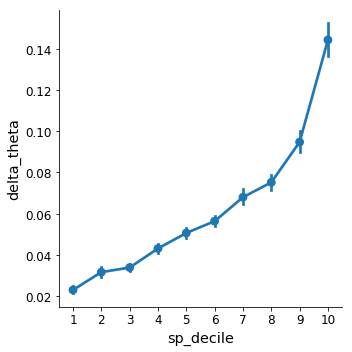

In [15]:
sns.factorplot(data=passive_phases, x='sp_decile', y='delta_theta', kind='point')

Finally, $\Delta t$ (inter-adjustment interval) decreases with starting point, which is against the hypothesis of either fixed threshold or fixed refractory period

C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


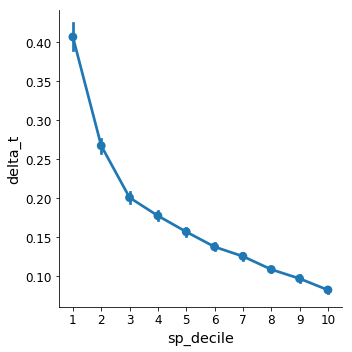

In [13]:
sns.factorplot(data=passive_phases, x='sp_decile', y='delta_t', kind='point')